# L4: Classification
[1. Setup](#1.-Setup)\
[2. An overview of MNIST](#2.-An-overview-of-MNIST)\
[3. Training a Binary Classifier](#3.-Training-a-Binary-Classifier)\
[4. Performance Measures](#4.-Performance-Measures)\
[5. Multiclass Classification](#5.-Multiclass-Classification)\
[6. Error Analysis](#6.-Error-Analysis)\
[7. Multilabel Classification](#7.-Multilabel-Classification)\
[8. Multioutput Classification](#8.-Multioutput-Classification)

# 1. Setup

Import `Scikit-Learn`

In [1]:
import sklearn

Define the default font sizes to make the figures prettier

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Create the `images/classification` folder (if it doesn't already exist)

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

Define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. An overview of MNIST

**Download `MNIST` dataset**

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

Print the description of `MNIST` dataset

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**Define data and target as arrays**\
`mnist.data` -> **X**\
`mnist.target` -> **y**

In [8]:
X, y = mnist.data, mnist.target

In [9]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
X.shape

(70000, 784)

In [11]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [12]:
y.shape

(70000,)

**Show the MNIST images**\
Before printing the images, we need to reshape the structure of each example from $1×784$ to $28×28$\
Note: in traing the model, we still use $1×784$ as the feature structure of each example

In [13]:
28 * 28

784

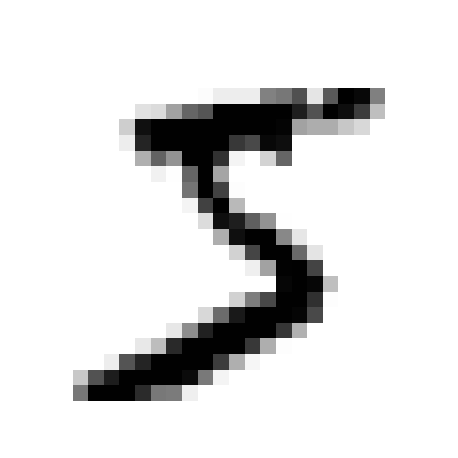

In [14]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [15]:
y[0]

'5'

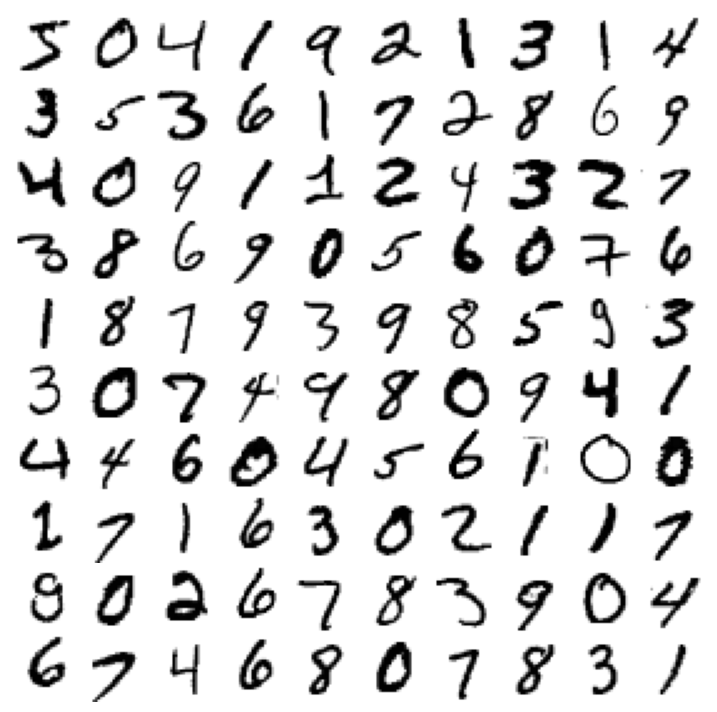

In [16]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

**Define traning set and test set**\
The MNIST dataset returned by `fetch_openml()` is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images)\
Note: [this webpage](https://www.geeksforgeeks.org/python-arrays/) shows you how to perform array operations in Python (for example, slicing of an array)

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3. Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. \
This **“5-detector”** will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5.\
First we’ll create the target vectors for this classification task:

In [18]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a **stochastic gradient descent** (SGD, or stochastic GD) classifier, using Scikit-Learn’s `SGDClassifier` class.\
Let’s create an `SGDClassifier` and train it on the whole training set:

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5

In [20]:
sgd_clf.predict([some_digit]) # here some_digit is X[0]

array([ True])

# 4. Performance Measures

## Measuring Accuracy Using Cross-Validation (not a good measure)

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using k-fold cross-validation with three folds

In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

This 95% accuracy (ratio of correct predictions) is actually not amazing. Why?\
Let's take a look at a simple dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5)

In [22]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


The dummy classifier's accuracy ratio is 90%.

In [23]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

This demonstrates why **accuracy** is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the **confusion matrix (CM)**.

## Confusion Matrix

The general idea of a **confusion matrix** is to count the number of times instances of class A are classified as class B, for all A/B pairs. \
Just like the cross_val_score() function, `cross_val_predict()` performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an *actual class*, while each column represents a *predicted class*.

\begin{array}{c|c}
\color{green}{TN} & \color{red}{FN} \\
\text{y_train_5=0} & \text{y_train_5=0} \\
\text{y_train_pred=0} & \text{y_train_pred=1} \\
\hline
\color{red}{FP} & \color{green}{TP} \\
\text{y_train_5=1} & \text{y_train_5=1} \\
\text{y_train_pred=0} & \text{y_train_pred=1} \\
\end{array}

The first row of this matrix considers non-5 images (the negative class): 

* 53,892 of them were correctly classified as non-5s (they are called <font color='green'>**true negatives** ($TN$)</font>)
* the remaining 687 were wrongly classified as 5s (<font color='red'>**false positives** ($FP$)</font>, also called **type I errors**). 

The second row considers the images of 5s (the positive class): 

* 1,891 were wrongly classified as non-5s (<font color='red'>**false negatives** ($FN$)</font>, also called **type II errors**)
* the remaining 3,530 were correctly classified as 5s (<font color='green'>**true positives** ($TP$)</font>). 

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [26]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## Precision and Recall

The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric.\
**Precision** of the classifier: the accuracy of the positive predictions\
$\text{Precision}=\dfrac{\color{green}{TP}}{\color{green}{TP}+\color{red}{FP}}$\
<font color='green'>$TP$</font> is the number of true positives, <font color='red'>$FP$</font> is the number of false positives

In [27]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [28]:
# extra code – this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

**Recall** of the classifier: the ratio of positive instances that are correctly detected by the classifier\
$\text{Recall}=\dfrac{\color{green}{TP}}{\color{green}{TP}+\color{red}{FN}}$\
<font color='green'>$TP$</font> is the number of true positives, <font color='red'>$FN$</font> is the number of false negatives

In [29]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [30]:
# extra code – this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy:
* When it claims an image represents a 5, it is correct only 83.7% of the time.
* It only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the **$F_1$ score**.\
**$F_1$ score** is the harmonic mean of precision and recall \
$F_1=\dfrac{2}{\frac{1}{precision}+\frac{1}{recall}}=2\times\dfrac{precision \times recall}{precision + recall}=\dfrac{TP}{TP+\frac{1}{2}(FP+FN)}$

In [31]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [32]:
# extra code – this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

## Precision/Recall Trade-off

Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. \
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**.

To understand this trade-off, let’s look at how the `SGDClassifier` makes its **classification decisions**. 
* For each instance, it computes a score based on a decision function. 
* If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [35]:
y_some_digit_pred

array([ True])

In [36]:
# extra code – just shows that y_scores > 0 produces the same result as
#              calling predict()
y_scores > 0

array([ True])

In [37]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How do you decide which threshold to use? \
First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

**Precision and recall vs. the decision threshold**

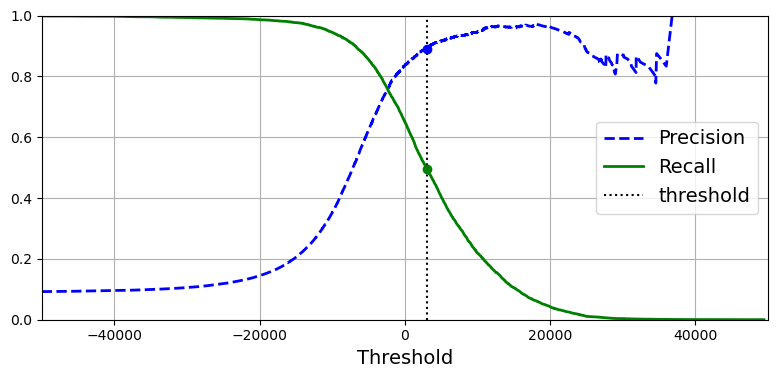

In [40]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

**Precision vs. recall (PR Curve)**

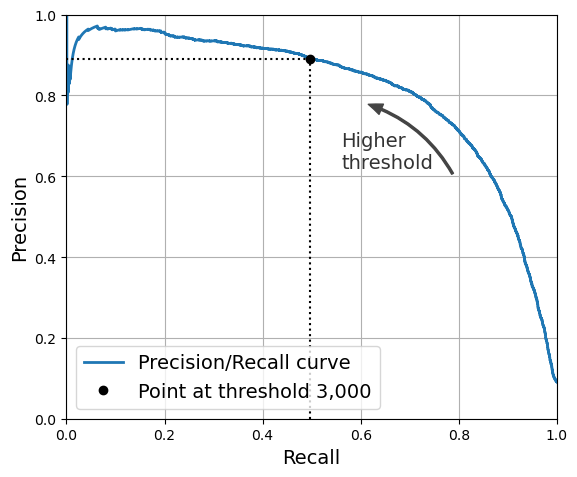

In [41]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

Suppose you decide to aim for 90% precision. You can search for the lowest threshold that gives you at least 90% precision. 
For this, you can use the NumPy array’s `argmax()` method. This returns the first index of the maximum value, which in this case means the first True value:

In [42]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s `predict()` method, you can run this code:

In [43]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

The **receiver operating characteristic (ROC) curve** is another common tool used with binary classifiers. \
It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the **true positive rate (TNR)** (another name for recall) against the **false positive rate (FPR)**. The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the **ROC curve**, we first use the `roc_curve()` function to compute the TPR and FPR for various threshold values:

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

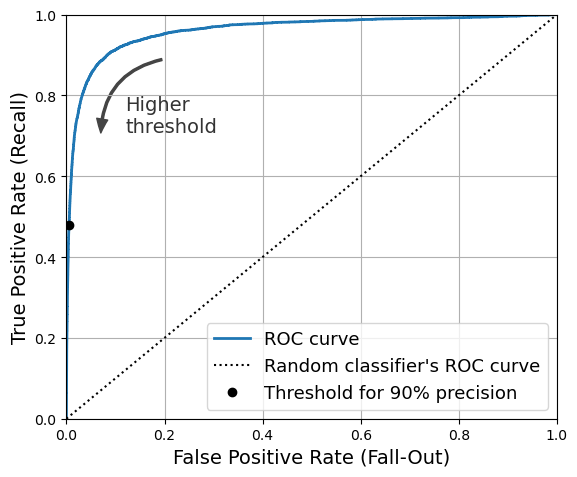

In [47]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. \
The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve (AUC)**. 
* a perfect classifier will have a ROC AUC equal to 1
* a purely random classifier will have a ROC AUC equal to 0.5

Scikit-Learn provides a function to estimate the ROC AUC:

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a `RandomForestClassifier` for comparison \
**Warning:** the following cell may take a few minutes to run.

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The `RandomForestClassifier` class does not have a `decision_function()` method, due to the way it works. \
Luckily, it has a `predict_proba()` method that returns **class probabilities** for each instance, and we can just use the probability of the positive class as a score, so it will work fine.

In [50]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let’s look at the class probabilities for the first two images in the training set. The model predicts that
* the first image is positive with 89% probability
* the second image is negative with 99% probability

Since each image is either positive or negative, the probabilities in each row add up to 100%.

In [51]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

These are _estimated probabilities_. Among the images that the model classified as positive with a probability between 50% and 60%, there are actually about 94% positive images. So, the model’s estimated probabilities were much too low in this case—but models can be overconfident as well. 

In [52]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


The second column contains the estimated probabilities for the positive class, so let’s pass them to the `precision_recall_curve()` function:

In [53]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Now we’re ready to plot the **PR curve** (Presion vs. Recall)

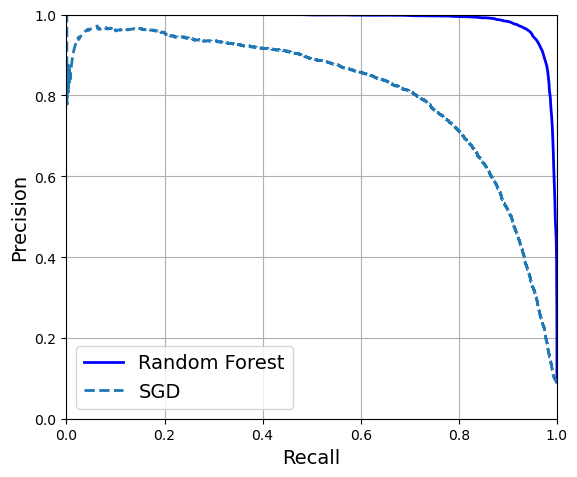

In [54]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

The `RandomForestClassifier`’s PR curve looks much better than the `SGDClassifier`’s: it comes much closer to the top-right corner. 

Its F1 score and ROC AUC score are also significantly better:

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [55]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [56]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [57]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [58]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# 5. Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs one-versus-the-rest (OvR) or one-versus-one (OvO), depending on the algorithm.

**Example 1: Support vector machine classifier (using OvO)**

Let’s try this with a support vector machine classifier using the `sklearn.svm.SVC` class.\
SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [59]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [60]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels. \
If you call the `decision_function()` method, you will see that it returns 10 scores per instance: one per class. 

In [61]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [62]:
class_id = some_digit_scores.argmax()
class_id

5

In the case of MNIST, the index of each class in the `classes_ array` conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'), but in general you won’t be so lucky; you will need to look up the class label like this:

In [63]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [64]:
svm_clf.classes_[class_id]

'5'

**Example 2: Support vector machine classifier (using OvR)**

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes.

In [65]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let’s make a prediction

In [66]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

Check the number of trained classifiers

In [67]:
len(ovr_clf.estimators_)

10

**Example 3: Stochastic gradient descent classifier (using OvR)**

Training an `SGDClassifier` on a multiclass dataset and using it to make predictions:

In [68]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [69]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

**Warning:** the following cells may take a few minutes each to run:

You can use the `cross_val_score()` function to evaluate the model.

In [70]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs increases accuracy above 89.1%:

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 6. Error Analysis

Let's look at the confusion matrix in three steps:
* make predictions using the `cross_val_predict()` function
* pass the labels and predictions to the `confusion_matrix()` function
* plot a colored diagram of the confusion matrix using the `ConfusionMatrixDisplay.from_predictions()` function

**Warning:** the following cell will take a few minutes to run:

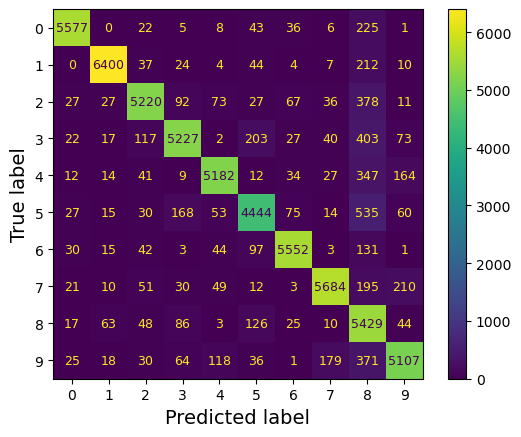

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

normalize the confusion matrix by dividing each value by the total number of images in the corresponding (true) class (i.e., divide by the row’s sum). This can be done simply by setting `normalize="true"` We can also specify the `values_format=".0%"` argument to show percentages with no decimals. 

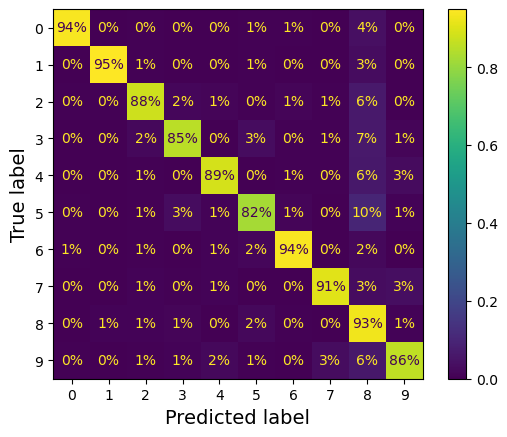

In [73]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Now we can easily see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s.\
If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immediately obvious from this diagram.\
If you want to make the errors stand out more, you can try putting zero weight on the correct predictions by setting `sample_weight`. 

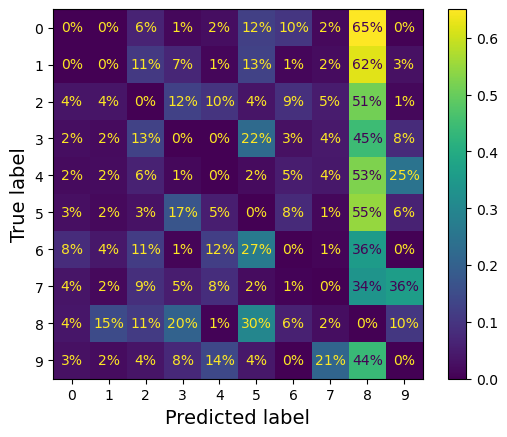

In [74]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

Let's put all plots in a couple of figures


**Confusion matrix (left) and the same CM normalized by row (right)**

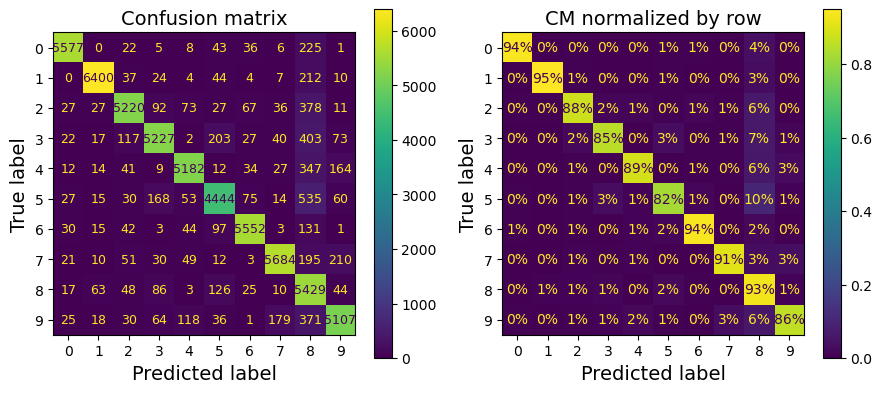

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

**Confusion matrix with errors only, normalized by row (left) and by column (right)**
* Left: many images got misclassified as 8s.
* Right: 56% of misclassified 7s are actually 9s

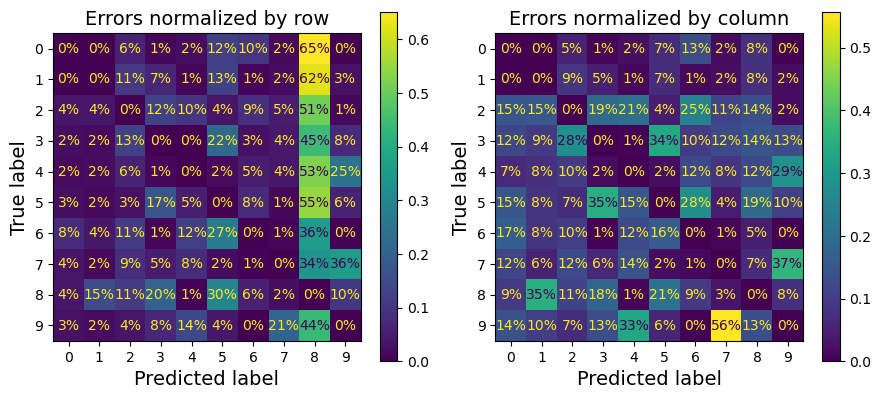

In [76]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # make fonts great again

Analyzing individual errors can also be a good way to gain insights into what your classifier is doing and why it is failing. \
For example, let’s plot examples of 3s and 5s in a confusion matrix style.

In [77]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

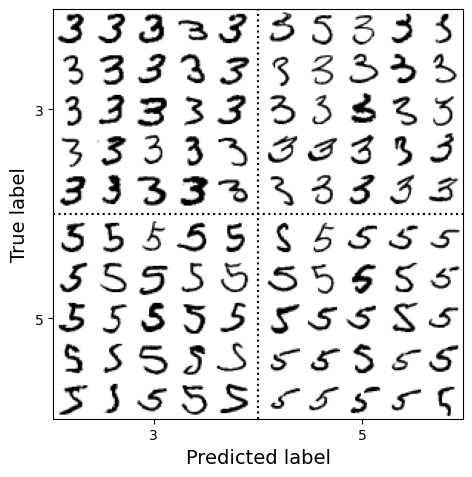

In [78]:
# Some images of 3s and 5s organized like a confusion matrix
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

# 7. Multilabel Classification

This code creates a `y_multilabel` array containing two target labels for each digit image: 
* the first indicates whether or not the digit is large (7, 8, or 9)
* the second indicates whether or not it is odd

In [79]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

**KNeighborsClassifier**

Let's create a `KNeighborsClassifier` instance, which supports multilabel classification (not all classifiers do), and train this model using the multiple targets array

In [80]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Now you can make a prediction, and notice that it outputs two labels:

In [81]:
knn_clf.predict([some_digit])

array([[False,  True]])

Compute the average F1 score across all labels (equal weighted)\
**Warning**: the following cells may take a few minutes to run:

In [82]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Compute the average F1 score across all labels (weighted by the number of instances with that target label)\
**Warning**: the following cells may take a few minutes to run:

In [83]:
# extra code – shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

**ChainClassifier**\
If you wish to use a classifier that does not natively support multilabel classification, such as SVC, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the **dependencies** between the labels. For example, a large digit (7, 8, or 9) is twice more likely to be odd than even, but the classifier for the “odd” label does not know what the classifier for the “large” label predicted. To solve this issue, the models can be organized in a **chain**: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain.\
Scikit-Learn has a class called `ChainClassifier` that does just that.  Let's just use the first 2,000 images in the training set to speed things up:

In [84]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [85]:
chain_clf.predict([some_digit])

array([[0., 1.]])

# 8. Multioutput Classification

It is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).\
To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. 

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s `randint()` function. The target images will be the original images:

In [86]:
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let’s take a look at the first image from the test set:\
On the left is the noisy input image, and on the right is the clean target image.

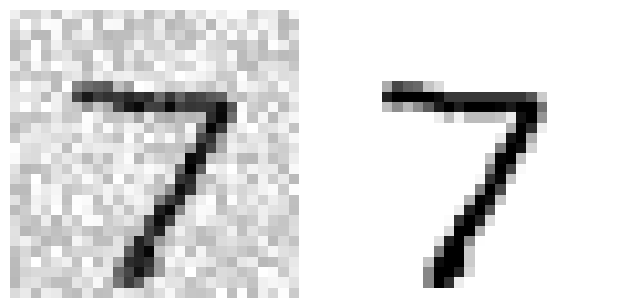

In [87]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

Now let’s train the classifier and make it clean up this image 

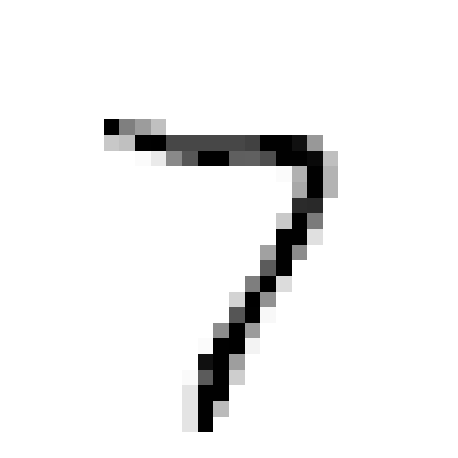

In [88]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # extra code – saves Figure 3–13
plt.show()